In [ ]:
!pip install --no-deps pyod river


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score

from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM

from river.drift import ADWIN

print("Imports succeeded.")


Imports succeeded.


In [ ]:
from google.colab import files
uploaded_files = files.upload()
print("Uploaded:", list(uploaded_files.keys()))


Saving train_FD001.txt to train_FD001.txt
Uploaded: ['train_FD001.txt']


In [ ]:
import pandas as pd

col_names = (
    ['unit','cycle'] +
    [f'op_{i}' for i in range(1,4)] +
    [f'sensor_{i}' for i in range(1,22)]
)
df_all = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
df = df_all[df_all['unit']==1].sort_values('cycle').reset_index(drop=True)
df = df.drop(columns=['unit','op_1','op_2','op_3'])
df.head()


,cycle,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,2,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,3,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,4,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,5,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
import numpy as np

np.random.seed(42)
n_rows = df.shape[0]
n_anom = int(0.05 * n_rows)

idx_pre  = df[df['cycle'] < 80].index.to_numpy()
idx_mid  = df[(df['cycle'] >= 80) & (df['cycle'] <= 120)].index.to_numpy()
idx_post = df[df['cycle'] > 120].index.to_numpy()

k_pre  = n_anom // 3
k_mid  = n_anom // 3
k_post = n_anom - k_pre - k_mid

anoms_pre  = np.random.choice(idx_pre,  size=k_pre,  replace=False)
anoms_mid  = np.random.choice(idx_mid,  size=k_mid,  replace=False)
anoms_post = np.random.choice(idx_post, size=k_post, replace=False)
anomaly_indices = np.concatenate([anoms_pre, anoms_mid, anoms_post])


df['is_anomaly'] = 0
df.loc[anomaly_indices, 'is_anomaly'] = 1

for idx in anomaly_indices:
    noise = np.random.normal(loc=0.5, scale=0.1, size=5)
    df.loc[idx, [f'sensor_{i}' for i in range(1,6)]] += noise

df.head(10)

,cycle,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,is_anomaly
0,1,519.200155,642.316529,1590.083132,1401.214282,15.195193,21.61,554.36,2388.06,9046.19,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1
1,2,518.670000,642.150000,1591.820000,1403.140000,14.620000,21.61,553.75,2388.04,9044.07,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
2,3,518.670000,642.350000,1587.990000,1404.200000,14.620000,21.61,554.26,2388.08,9052.94,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
3,4,518.670000,642.350000,1582.790000,1401.870000,14.620000,21.61,554.45,2388.11,9049.48,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
4,5,518.670000,642.370000,1582.850000,1406.220000,14.620000,21.61,554.00,2388.06,9055.15,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
5,6,518.670000,642.100000,1584.470000,1398.370000,14.620000,21.61,554.67,2388.02,9049.68,...,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,0
6,7,518.670000,642.480000,1592.320000,1397.770000,14.620000,21.61,554.34,2388.02,9059.13,...,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,0
7,8,518.670000,642.560000,1582.960000,1400.970000,14.620000,21.61,553.85,2388.00,9040.80,...,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,0
8,9,518.670000,642.120000,1590.980000,1394.800000,14.620000,21.61,553.69,2388.05,9046.46,...,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,0
9,10,518.670000,641.710000,1591.240000,1400.460000,14.620000,21.61,553.59,2388.05,9051.70,...,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,0


In [ ]:
def drift_multiplier(cycle):
    if cycle < 80:
        return 1.0
    elif cycle > 120:
        return 1.5
    else:
        return 1.0 + 0.0125 * (cycle - 80)

df_drifted = df.copy()
for idx, row in df.iterrows():
    m = drift_multiplier(row['cycle'])
    df_drifted.loc[idx, [f'sensor_{i}' for i in range(1, 6)]] = (
        row[[f'sensor_{i}' for i in range(1, 6)]] * m
    )

df_drifted.head(10)


,cycle,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,is_anomaly
0,1,519.200155,642.316529,1590.083132,1401.214282,15.195193,21.61,554.36,2388.06,9046.19,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1
1,2,518.670000,642.150000,1591.820000,1403.140000,14.620000,21.61,553.75,2388.04,9044.07,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0
2,3,518.670000,642.350000,1587.990000,1404.200000,14.620000,21.61,554.26,2388.08,9052.94,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0
3,4,518.670000,642.350000,1582.790000,1401.870000,14.620000,21.61,554.45,2388.11,9049.48,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0
4,5,518.670000,642.370000,1582.850000,1406.220000,14.620000,21.61,554.00,2388.06,9055.15,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0
5,6,518.670000,642.100000,1584.470000,1398.370000,14.620000,21.61,554.67,2388.02,9049.68,...,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,0
6,7,518.670000,642.480000,1592.320000,1397.770000,14.620000,21.61,554.34,2388.02,9059.13,...,2388.03,8132.32,8.3974,0.03,392,2388,100.0,39.10,23.3774,0
7,8,518.670000,642.560000,1582.960000,1400.970000,14.620000,21.61,553.85,2388.00,9040.80,...,2388.03,8131.07,8.4076,0.03,391,2388,100.0,38.97,23.3106,0
8,9,518.670000,642.120000,1590.980000,1394.800000,14.620000,21.61,553.69,2388.05,9046.46,...,2388.05,8125.69,8.3728,0.03,392,2388,100.0,39.05,23.4066,0
9,10,518.670000,641.710000,1591.240000,1400.460000,14.620000,21.61,553.59,2388.05,9051.70,...,2388.06,8129.38,8.4286,0.03,393,2388,100.0,38.95,23.4694,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = [f'sensor_{i}' for i in range(1, 22)]
scaler = MinMaxScaler()

pre_mask = df_drifted['cycle'] < 80
scaler.fit(df_drifted.loc[pre_mask, feature_cols])

df_norm = df_drifted.copy()
df_norm[feature_cols] = scaler.transform(df_drifted[feature_cols])

df_norm.head(10)


,cycle,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,is_anomaly
0,1,0.915475,0.445977,0.623119,0.534078,1.0,0.0,0.687500,0.500000,0.264086,...,0.263158,0.871895,0.546326,0.0,0.50,0.0,0.0,0.76,0.694832,1
1,2,0.000000,0.323529,0.721749,0.694421,0.0,0.0,0.369792,0.333333,0.160216,...,0.526316,0.405882,0.677316,0.0,0.50,0.0,0.0,0.64,0.712184,0
2,3,0.000000,0.470588,0.504259,0.782681,0.0,0.0,0.635417,0.666667,0.594806,...,0.315789,0.519608,0.528222,0.0,0.00,0.0,0.0,0.54,0.412674,0
3,4,0.000000,0.470588,0.208972,0.588676,0.0,0.0,0.734375,0.916667,0.425282,...,0.578947,0.558824,0.000000,0.0,0.50,0.0,0.0,0.40,0.524708,0
4,5,0.000000,0.485294,0.212379,0.950874,0.0,0.0,0.500000,0.500000,0.703087,...,0.368421,0.556863,0.651757,0.0,0.75,0.0,0.0,0.44,0.639759,0
5,6,0.000000,0.286765,0.304373,0.297252,0.0,0.0,0.848958,0.166667,0.435081,...,0.315789,0.494771,0.453674,0.0,0.25,0.0,0.0,0.60,0.498303,0
6,7,0.000000,0.566176,0.750142,0.247294,0.0,0.0,0.677083,0.166667,0.898089,...,0.315789,0.460131,0.310969,0.0,0.50,0.0,0.0,0.84,0.537910,0
7,8,0.000000,0.625000,0.218626,0.513739,0.0,0.0,0.421875,0.000000,0.000000,...,0.315789,0.378431,0.419595,0.0,0.25,0.0,0.0,0.58,0.285930,0
8,9,0.000000,0.301471,0.674049,0.000000,0.0,0.0,0.338542,0.416667,0.277315,...,0.421053,0.026797,0.048988,0.0,0.50,0.0,0.0,0.74,0.648057,0
9,10,0.000000,0.000000,0.688813,0.471274,0.0,0.0,0.286458,0.416667,0.534052,...,0.473684,0.267974,0.643237,0.0,0.75,0.0,0.0,0.54,0.884949,0


In [ ]:
mask_pre   = df_norm['cycle'] < 80
mask_mid   = (df_norm['cycle'] >= 80) & (df_norm['cycle'] <= 120)
mask_post  = df_norm['cycle'] > 120

X_all = df_norm[[f'sensor_{i}' for i in range(1, 22)]].values
y_all = df_norm['is_anomaly'].values

X_pre,  y_pre  = X_all[mask_pre],  y_all[mask_pre]
X_mid,  y_mid  = X_all[mask_mid],  y_all[mask_mid]
X_post, y_post = X_all[mask_post], y_all[mask_post]


In [ ]:
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM

clf_if = IForest(n_estimators=100, contamination=0.05, random_state=42)
clf_if.fit(X_pre)

clf_ocsvm = OCSVM(kernel='rbf', nu=0.05, gamma='scale')
clf_ocsvm.fit(X_pre)

y_if_pre   = clf_if.labels_                  # pre-drift
y_if_mid   = clf_if.predict(X_mid)           # mid-drift
y_if_post  = clf_if.predict(X_post)          # post-drift

y_svm_pre  = clf_ocsvm.labels_
y_svm_mid  = clf_ocsvm.predict(X_mid)
y_svm_post = clf_ocsvm.predict(X_post)


In [ ]:
from river.drift import ADWIN

adwin = ADWIN(delta=0.002)
adwin_flags = np.zeros(len(df_norm), dtype=int)

for idx, row in df_norm.iterrows():
    val = row[[f'sensor_{i}' for i in range(1, 6)]].sum()
    if adwin.update(val):
        adwin_flags[idx] = 1

y_adw_pre  = adwin_flags[mask_pre]
y_adw_mid  = adwin_flags[mask_mid]
y_adw_post = adwin_flags[mask_post]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred):
    return (
        precision_score(y_true, y_pred, zero_division=0),
        recall_score(y_true, y_pred, zero_division=0),
        f1_score(y_true, y_pred, zero_division=0)
    )

m_if_pre   = compute_metrics(y_pre,   y_if_pre)
m_if_mid   = compute_metrics(y_mid,   y_if_mid)
m_if_post  = compute_metrics(y_post,  y_if_post)

m_svm_pre  = compute_metrics(y_pre,   y_svm_pre)
m_svm_mid  = compute_metrics(y_mid,   y_svm_mid)
m_svm_post = compute_metrics(y_post,  y_svm_post)

m_adw_pre  = compute_metrics(y_pre,   y_adw_pre)
m_adw_mid  = compute_metrics(y_mid,   y_adw_mid)
m_adw_post = compute_metrics(y_post,  y_adw_post)

import pandas as pd

results = pd.DataFrame({
    'Model':   ['IF','IF','IF','SVM','SVM','SVM','ADWIN','ADWIN','ADWIN'],
    'Segment': ['Pre','Mid','Post']*3,
    'Precision': [
        m_if_pre[0],   m_if_mid[0],   m_if_post[0],
        m_svm_pre[0],  m_svm_mid[0],  m_svm_post[0],
        m_adw_pre[0],  m_adw_mid[0],  m_adw_post[0]
    ],
    'Recall': [
        m_if_pre[1],   m_if_mid[1],   m_if_post[1],
        m_svm_pre[1],  m_svm_mid[1],  m_svm_post[1],
        m_adw_pre[1],  m_adw_mid[1],  m_adw_post[1]
    ],
    'F1': [
        m_if_pre[2],   m_if_mid[2],   m_if_post[2],
        m_svm_pre[2],  m_svm_mid[2],  m_svm_post[2],
        m_adw_pre[2],  m_adw_mid[2],  m_adw_post[2]
    ]
})

results


,Model,Segment,Precision,Recall,F1
0,IF,Pre,0.750000,1.000000,0.857143
1,IF,Mid,0.075000,1.000000,0.139535
2,IF,Post,0.041667,1.000000,0.080000
3,SVM,Pre,0.250000,0.666667,0.363636
4,SVM,Mid,0.073171,1.000000,0.136364
5,SVM,Post,0.041667,1.000000,0.080000
6,ADWIN,Pre,0.000000,0.000000,0.000000
7,ADWIN,Mid,0.000000,0.000000,0.000000
8,ADWIN,Post,0.000000,0.000000,0.000000


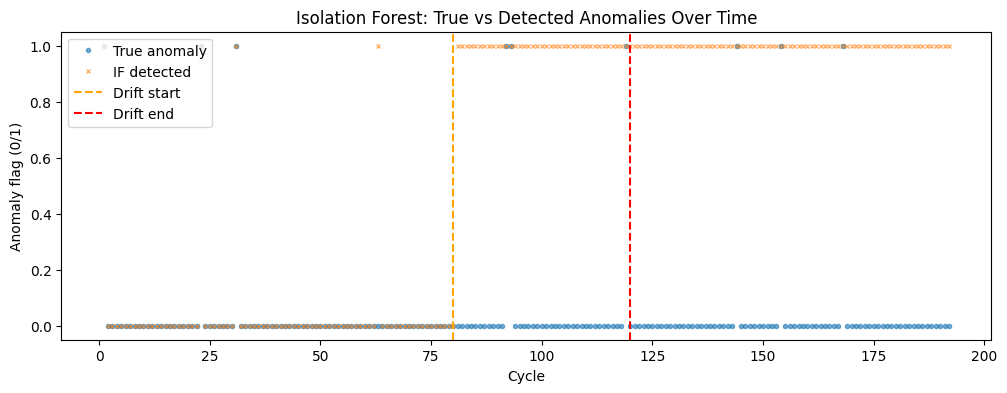

In [ ]:
import matplotlib.pyplot as plt

pred_if_all = np.concatenate([y_if_pre, y_if_mid, y_if_post])
cycles = df_norm['cycle'].to_numpy()

plt.figure(figsize=(12, 4))
plt.plot(cycles, df_norm['is_anomaly'],
         marker='o', linestyle='None', markersize=3, label='True anomaly', alpha=0.6)
plt.plot(cycles, pred_if_all,
         marker='x', linestyle='None', markersize=3, label='IF detected', alpha=0.6)
plt.axvline(80,  color='orange', linestyle='--', label='Drift start')
plt.axvline(120, color='red',    linestyle='--', label='Drift end')
plt.xlabel('Cycle')
plt.ylabel('Anomaly flag (0/1)')
plt.legend(loc='upper left')
plt.title('Isolation Forest: True vs Detected Anomalies Over Time')
plt.show()


In [ ]:
from sklearn.metrics import f1_score

f1_base_adw = m_adw_pre[2]
threshold = 0.9 * f1_base_adw

cycles_mid = df_norm['cycle'][mask_mid].to_numpy()
true_mid   = y_mid
pred_mid   = y_adw_mid

recovery_cycle = None
for i in range(len(true_mid) - 9):
    if f1_score(true_mid[i:i+10], pred_mid[i:i+10], zero_division=0) >= threshold:
        recovery_cycle = cycles_mid[i]
        break

print(f"ADWIN pre-drift F1: {f1_base_adw:.3f}")
print(f"Recovery threshold: {threshold:.3f}")
print(f"ADWIN recovery cycle: {recovery_cycle}")


ADWIN pre-drift F1: 0.000
Recovery threshold: 0.000
ADWIN recovery cycle: 80


In [ ]:
mask_upto120 = df_norm['cycle'] <= 120
X_retrain = df_norm.loc[mask_upto120, feature_cols].values

clf_if_rt = IForest(n_estimators=100, contamination=0.05, random_state=42)
clf_if_rt.fit(X_retrain)

y_if_rt_post = clf_if_rt.predict(X_post)

f1_pre_if  = m_if_pre[2]                       # F1 before drift
m_if_rt_post = compute_metrics(y_post, y_if_rt_post)
f1_rt_post = m_if_rt_post[2]                   # F1 after retrain

threshold_if = 0.9 * f1_pre_if

print(f"IF pre-drift F1:       {f1_pre_if:.3f}")
print(f"IF post-retrain F1:    {f1_rt_post:.3f}")
print(f"Recovery threshold:    {threshold_if:.3f}")
print("→ Retrain occurred at cycle 120; if post-retrain F1 ≥ threshold, IF has “recovered.”")


IF pre-drift F1:       0.857
IF post-retrain F1:    0.080
Recovery threshold:    0.771
→ Retrain occurred at cycle 120; if post-retrain F1 ≥ threshold, IF has “recovered.”


In [ ]:
import pandas as pd

summary = pd.DataFrame({
    'Model': [
        'IF (pre)', 'IF (mid)', 'IF (post)',
        'IF (post-retrain)',
        'SVM (pre)', 'SVM (mid)', 'SVM (post)',
        'ADWIN (pre)', 'ADWIN (mid)', 'ADWIN (post)'
    ],
    'F1': [
        m_if_pre[2],   m_if_mid[2],       m_if_post[2],
        f1_rt_post,
        m_svm_pre[2],  m_svm_mid[2],      m_svm_post[2],
        m_adw_pre[2],  m_adw_mid[2],      m_adw_post[2]
    ]
})

summary


,Model,F1
0,IF (pre),0.857143
1,IF (mid),0.139535
2,IF (post),0.080000
3,IF (post-retrain),0.080000
4,SVM (pre),0.363636
5,SVM (mid),0.136364
6,SVM (post),0.080000
7,ADWIN (pre),0.000000
8,ADWIN (mid),0.000000
9,ADWIN (post),0.000000
